In [1]:
from core import *
from utils import *
from diagnostics import *
from fields import *
from constants import *
from distributions import *

from scipy import constants as sp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit

import cProfile

def plot_traj(history):
    fig = plt.figure(figsize = plt.figaspect(1) * 7)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(trials):
        pos = history[i, :, 0]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    plt.show()
    
def plot_gca(gca):
    fig = plt.figure(figsize = plt.figaspect(1) * 7)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(trials):
        pos = gca[i, :, :]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    plt.show()
    
def to_percent(observed, actual):
    return abs((observed - actual) / actual) * 100

Load IGRF coefficients ...


In [2]:
e_field = zero_field()
b_field = t89(1)
solve   = solver(relativistic_boris(e_field, b_field))

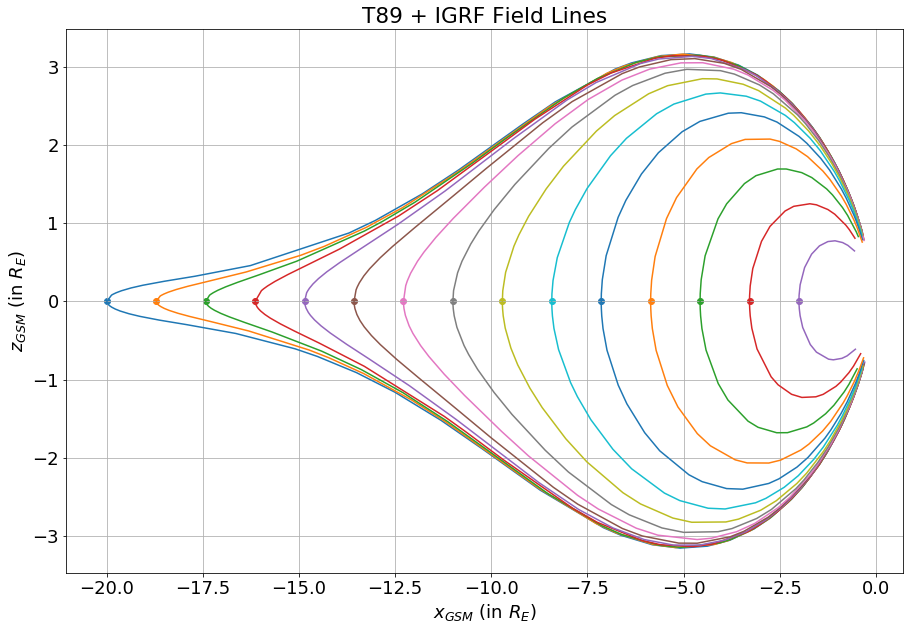

In [3]:
from field_utils import *

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 18})

for i, x in enumerate(np.linspace(-20 * Re, -2 * Re, 15)):
    rr = field_line(b_field, np.array([x, 0, 0]), 1e1)
    r_min = field_reversal(b_field, rr)
    
    plt.plot(rr[:, 0] / Re, rr[:, 2] / Re)
    plt.scatter(r_min[0] / Re, r_min[2] / Re)
    
plt.grid()
plt.xlabel('$x_{GSM}$ (in $R_E$)')
plt.ylabel('$z_{GSM}$ (in $R_E$)')
plt.title('T89 + IGRF Field Lines')
plt.show()

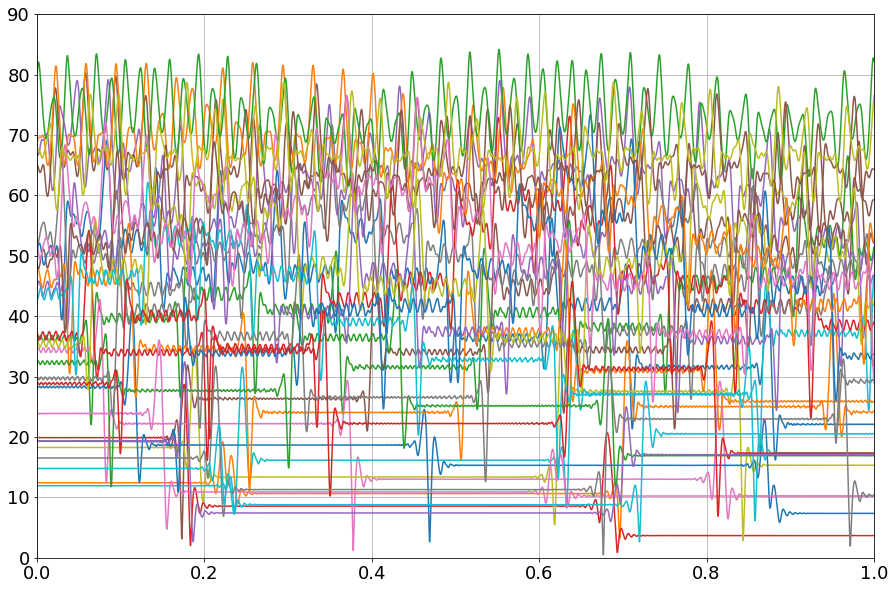

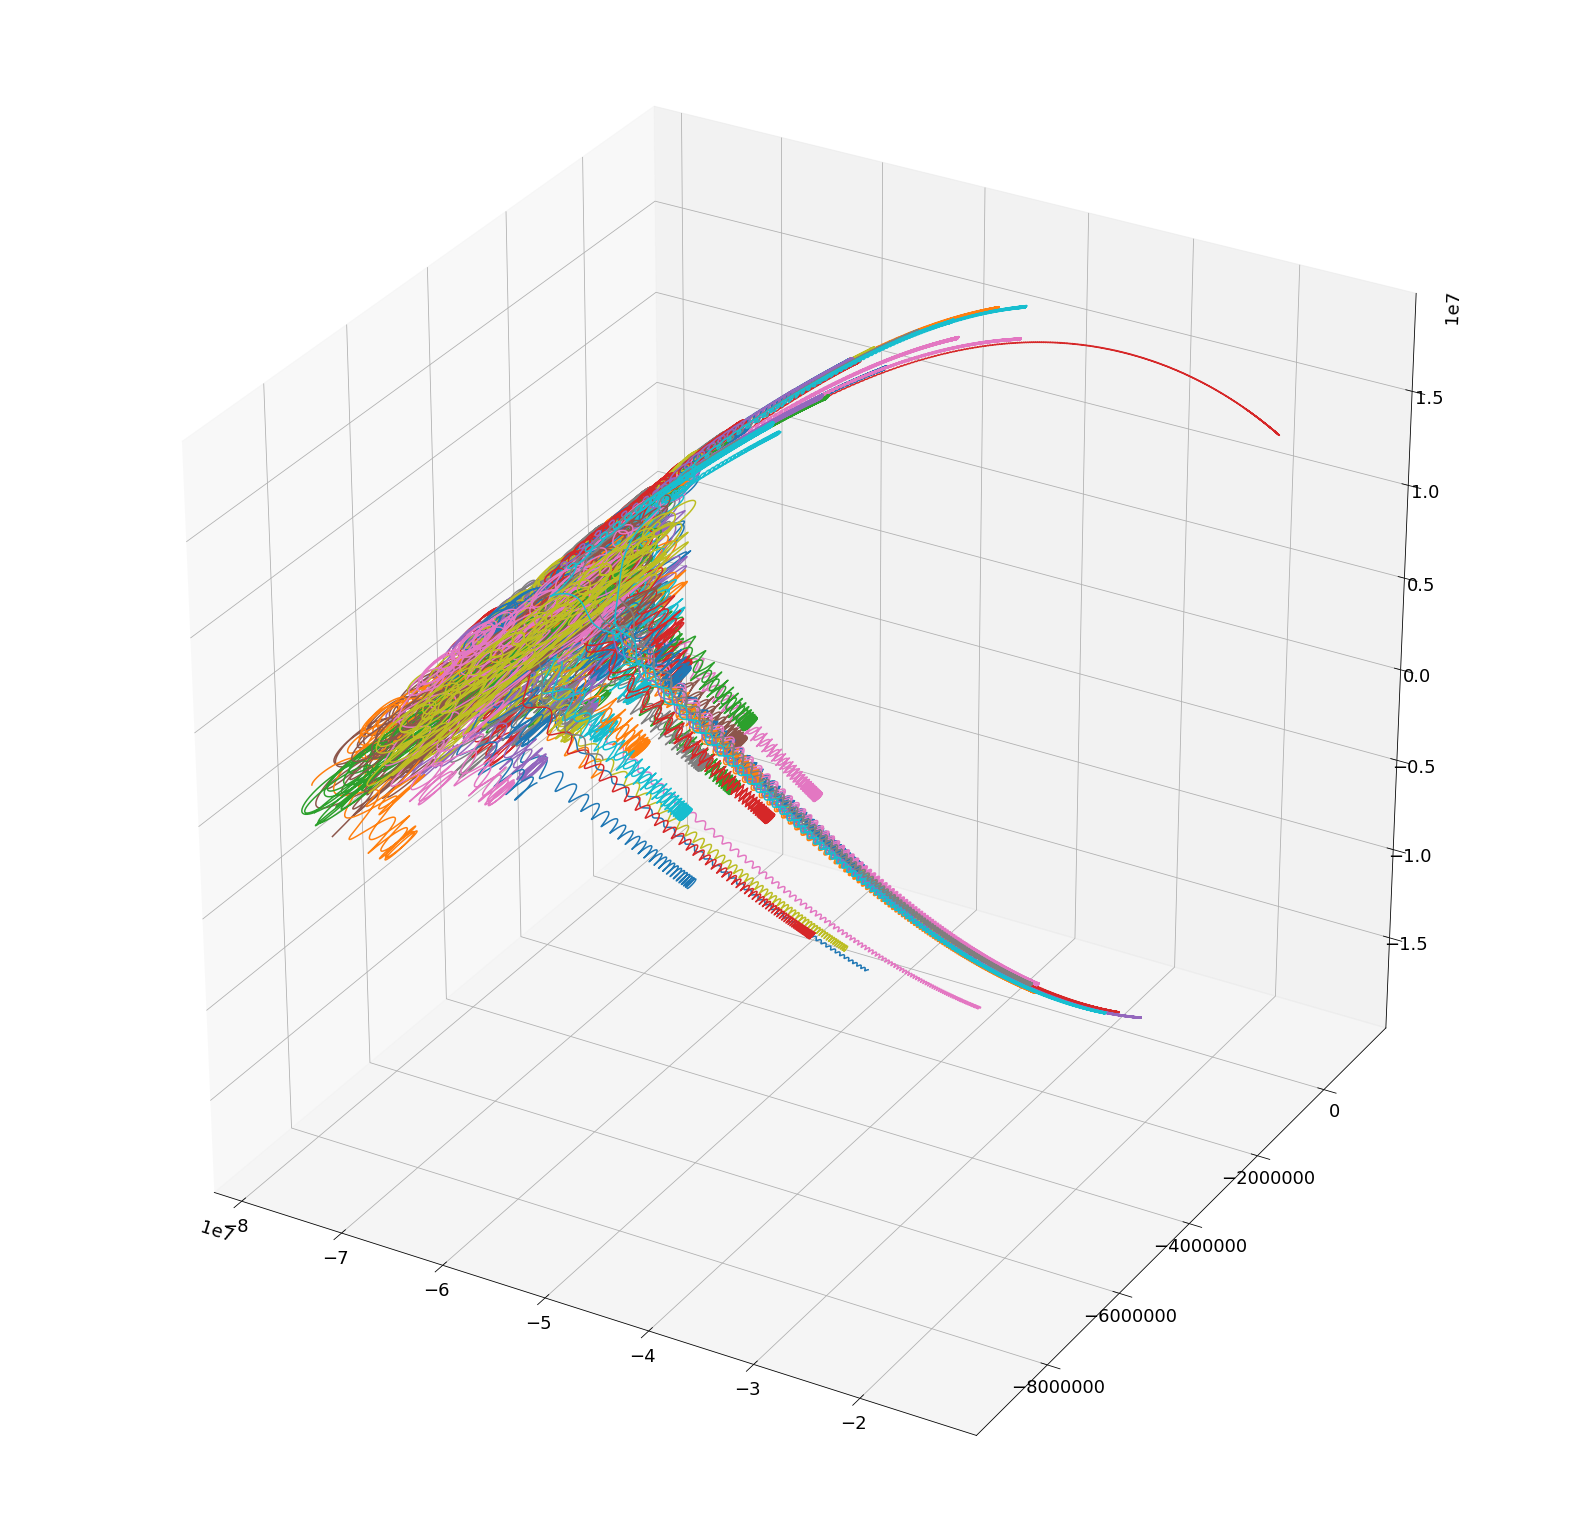

In [4]:
T      = 1           # Total time (in seconds)
dt     = 1e-4        # Simulation time step
trials = 30          # Number of runs
steps  = int(T / dt) # Number of steps per run

history, intrinsic = populate_by_eq_pa(trials,
                                       steps,
                                       e_field,
                                       b_field,
                                       delta(12),                               # re/Re of field line
                                       delta(1e6),                              # Kinetic energy (eV)
                                       uniform(np.radians(10), np.radians(80)), # Equatorial pitch angle
                                       uniform(0, 2 * np.pi)                    # Phase angle
                                      )

solve(history, intrinsic, dt)

eqpas = eq_pitch_angle_from_moment(history, intrinsic)
plt.figure(figsize=(15, 10))
for i in range(trials):
    plt.plot(np.arange(0, steps) * dt, eqpas[i])
    plt.grid()

plt.xlim([0, T])
plt.ylim([0, 90])
plt.grid()
plt.show()

plot_traj(history)

In [5]:
plot = plotter(history, intrinsic, dt)

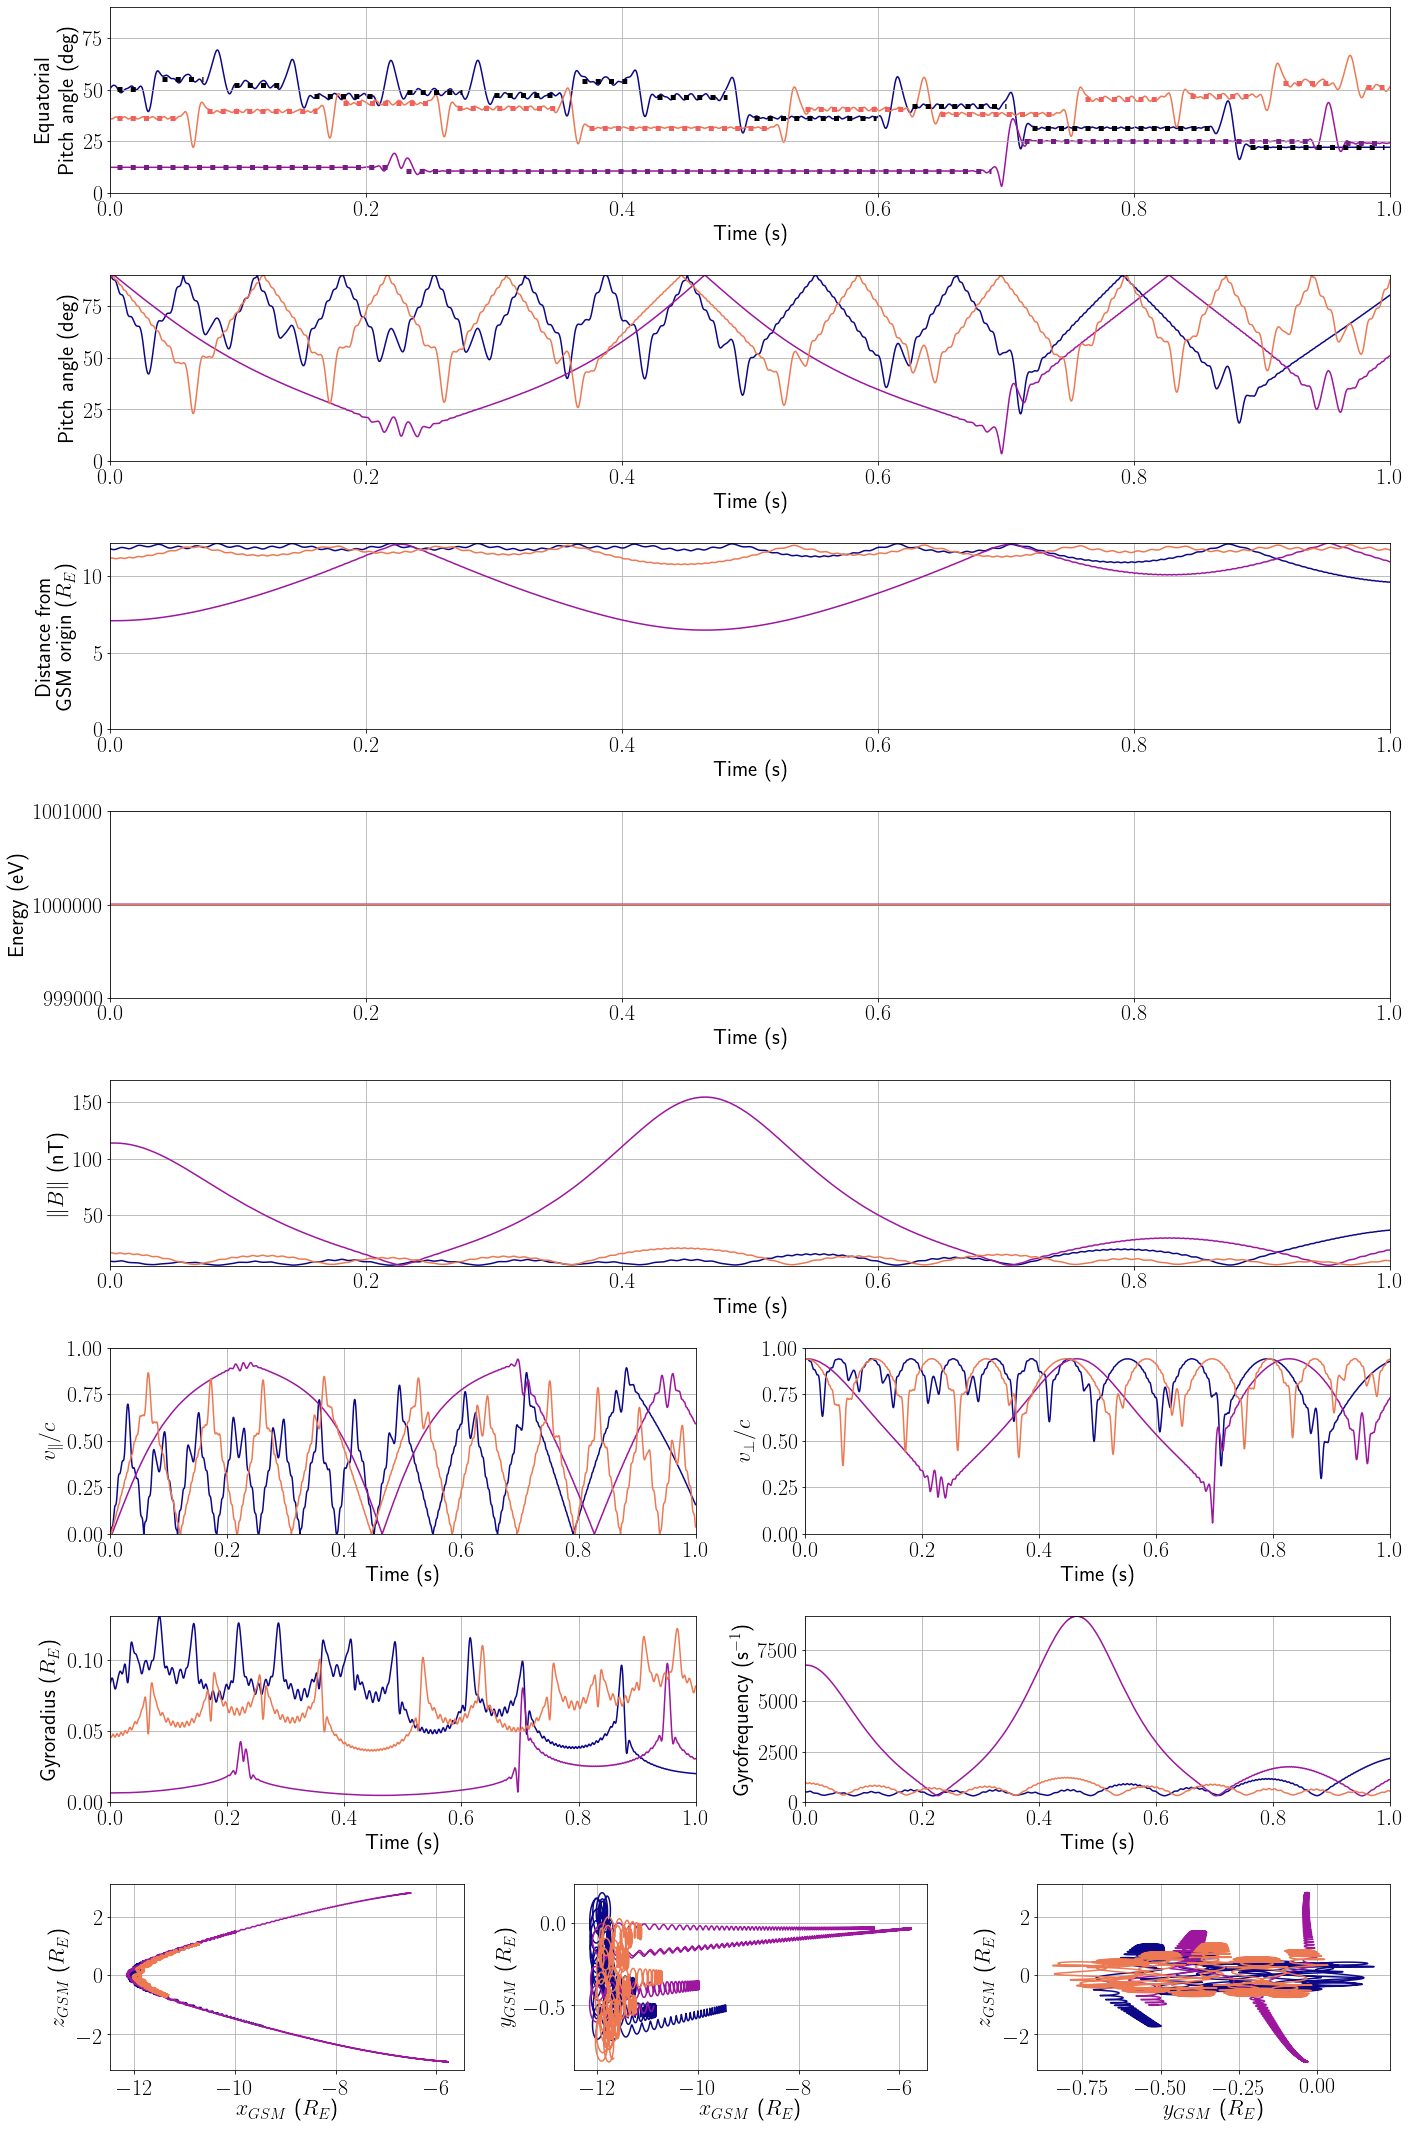

In [8]:
plot([0, 1, 2])

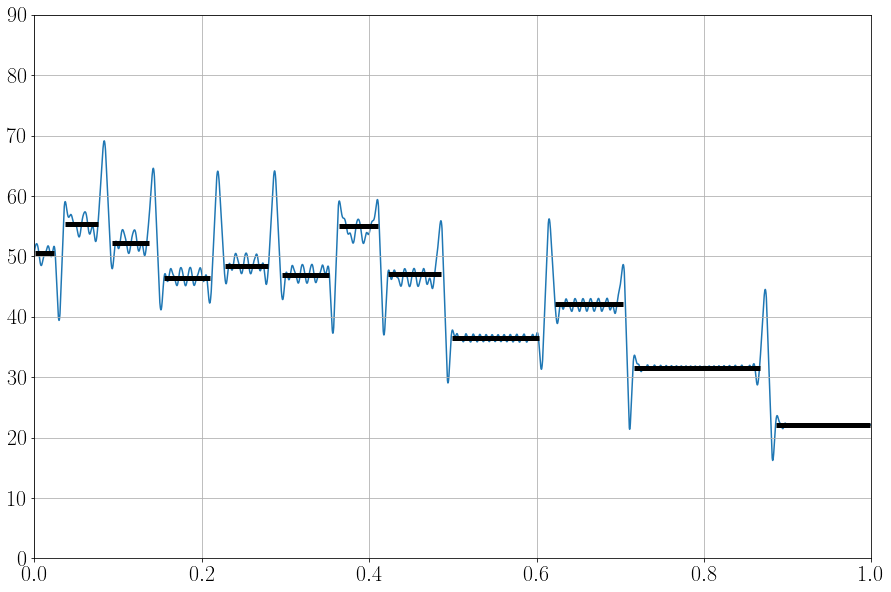

In [10]:
plt.figure(figsize=(15, 10))

i = 0
rms = eqpas[i]
centered = np.diff(rms, prepend=rms[0])
within_thresh = np.argwhere(np.abs(centered) <= 0.2)[:, 0]

plt.plot(within_thresh * dt, rms[within_thresh], zorder=1)

contiguous = np.diff(within_thresh, prepend=within_thresh[0])

endpoints = []

pad = 10
stretch = 50

endpoints = []
endpoints_tentative = np.where(np.concatenate(([contiguous[0]], contiguous[:-1] != contiguous[1:], [1])))[0] - 1
for i in range(int(len(endpoints_tentative) / 2)):
    if ((endpoints_tentative[2 * i + 1] - pad) - (endpoints_tentative[2 * i] + pad)) > stretch:
        endpoints.append(endpoints_tentative[2 * i] + pad)
        endpoints.append(endpoints_tentative[2 * i + 1] - pad)
        
for i in range(int(len(endpoints) / 2)):
    plt.hlines(np.mean(rms[within_thresh][endpoints[2 * i]:endpoints[2 * i + 1]]), within_thresh[endpoints[2 * i]] * dt, within_thresh[endpoints[2 * i + 1]] * dt, linestyle='-', linewidth=5, zorder=2)

plt.ylim([0, 90])
plt.xlim([0, 1])
plt.grid()
plt.show()